In [ ]:
# (for Google Colab)
!pip install pyDOE
!pip install tfp-nightly

In [ ]:
import os, time, pickle
import jax, flax, optax
import jax.numpy as np
from jax.nn.initializers import normal
import numpy as onp
from scipy.optimize import minimize
from functools import partial
from pyDOE import lhs
from typing import Sequence, Callable, Union, Dict
import json
from tensorflow_probability.substrates import jax as tfp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Must set CUDA_VISIBLE_DEVICES before importing JAX or any other library that initializes GPUs.
# Otherwise, the environment variable change might be ignored.
# "0, 1": first two GPUs / "": no GPU (CPU instead)

# Run on the first GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from jax.extend.backend import get_backend
print(get_backend().platform)

gpu


# Global Variables

In [ ]:
side_length = 1.
k = 100.
geo_bounds = {'lower': {'x_cen': -1., 'y_cen': -1., 'a': 0., 'b': 0., 'gamma': 0.},
              'upper': {'x_cen': 1., 'y_cen': 1., 'a': 1., 'b': 1., 'gamma': np.pi}}
# x_cen, y_cen, a, b, gamma = np.array([0.25, 0.25, 0.5, 6/20, float(onp.pi/3)])

# Hyperparameters

In [ ]:
architecture_list = [[140, 140, 140, 140, 140, 2]]
# architecture_list = [[20, 20, 2], [60, 60, 2],
#                      [20, 20, 20, 2], [60, 60, 60, 2],
#                      [20, 20, 20, 20, 2], [60, 60, 60, 60, 2],
#                      [20, 20, 20, 20, 20, 2], [60, 60, 60, 60, 60, 2],
#                      [120, 120, 120, 120, 120, 2]] # NN architecture list
lr = {"network": 1e-4,
      "x_cen":   1e-4,
      "y_cen":   1e-4,
      "a":       1e-4,
      "b":       1e-4,
      "gamma":   1e-4}
num_epochs = 40000 # number of training epochs
TV_weight = 1e-3

# NN Architecture

In [ ]:
# Define NN architecture
class PDESolution(flax.linen.Module): # inherit from Module class
    # One behavior of "flax.linen.Module" is to assign the provided argument to the "self.features"
    features: Sequence[int] # dataclass (e.g. [10, 20, 2])
    fourier_features: Union[None, Dict] = None

    @flax.linen.compact # a decorator to define the model in more concise and readable way
    def __call__(self, x): # __call__: makes an object callable, which enables you to use instances of the class like functions
        if self.fourier_features:
            x = FourierEmbbeding(**self.fourier_features)(x)

        for feature in self.features[:-1]:
            x = flax.linen.tanh(flax.linen.Dense(feature)(x))
        # Final Dense layer
        x = flax.linen.Dense(self.features[-1])(x)
        return x

# Fourier Feature Embedding

In [ ]:
# Mapping u(x)=NN(γ(x))
class FourierEmbbeding(flax.linen.Module):
    scale: float
    dim: int

    @flax.linen.compact
    def __call__(self, x):
        # Define random 'kernel' parameters in the network
        kernel = self.param('kernel', normal(self.scale), # Sample from N(0, σ²)
                            (x.shape[-1], self.dim // 2)) # shape of parameter
        # Projection from input vectors(x) -> random frequency vectors(γ(x))
        return np.concatenate([np.cos(np.dot(x, kernel)), np.sin(np.dot(x, kernel))], axis=-1)

# Dirichlet Boundary Conditions

In [ ]:
# Wrapper to apply Dirichlet BCs
# TODO: integrate other calculations into here as well
class ElasticityPINN(flax.linen.Module):
    features: Sequence[int]
    fourier_features: Union[None, Dict] = None

    # The setup() method is the standard place to define submodule with Flax.
    # It runs right before the model is called.
    def setup(self):
        self.model = PDESolution(self.features,
                                 fourier_features = self.fourier_features)

    def __call__(self, coords): # coords : (n, 2)
        # Raw output from the sub-module
        model_output = self.model(coords)
        x_coords = coords[:, 0]
        y_coords = coords[:, 1]

        # Hard-coded Dirichlet BCs
        u1 = (x_coords - 1) * (x_coords + 1) * model_output[:, 0] + 0.05 * x_coords
        u2 = (x_coords - 1) * (x_coords + 1) * model_output[:, 1] # Γ_u = 0 at y = -1, 1

        return np.stack([u1, u2], axis=1)

# Gaussian Quadrature

In [ ]:
def linear_transform(x, a, b, c=-1, d=1):
    return (b - a) / (d - c) * x + (a * d - b * c) / (d - c)

# Generate 1D points
def get_1D_quad_point(num_elems, num_gauss):
    # Gauss quadrature points & weights on [-1, 1]
    gauss_pts, gauss_weights = onp.polynomial.legendre.leggauss(num_gauss)

    # Mesh (points) generation
    mesh_pts = onp.linspace(-side_length, side_length, num_elems + 1)

    coords, weights = [], []
    for i in range(num_elems):
        # Vertices of the mesh
        a, b = mesh_pts[i], mesh_pts[i+1]

        # Linear transformation (Gauss points -> Physical points)
        physical_pts = linear_transform(gauss_pts, a, b) # (num_gauss,)

        # Jacobian (length of element / 2)
        J = 0.5 * (b - a)

        coords.append(physical_pts) # (n, num_gauss)
        weights.append(J * gauss_weights)

    return onp.array(coords).flatten(), onp.array(weights).flatten() # (n, num_gauss), (n, num_gauss) -> (n*num_gauss), (n*num_gauss)

# Generate 2D points
def get_2D_quad_point(x_elems, y_elems, num_gauss):
    # Gauss quadrature points & weights on [-1, 1] x [-1, 1]
    gauss_pts, gauss_weights = onp.polynomial.legendre.leggauss(num_gauss)

    # Generate weights on the all the grid points
    gauss_weight_x, gauss_weight_y = onp.meshgrid(gauss_weights, gauss_weights, indexing='ij') # if same quad pts in both axes, same results regardless of indexing
    gauss_weight_x, gauss_weight_y = gauss_weight_x.flatten(), gauss_weight_y.flatten()
    gauss_weight_total = gauss_weight_x * gauss_weight_y # weight at 2D points is the product of 1D weights

    # Generate points on the all the grid points
    # these grid points are used only for generating integration points, not for integration itself
    x_pts = onp.linspace(-side_length, side_length, x_elems + 1)
    y_pts = onp.linspace(-side_length, side_length, y_elems + 1)
    mesh_x, mesh_y = onp.meshgrid(x_pts, y_pts, indexing='ij')
    # mesh_x, mesh_y = mesh_x.flatten(), mesh_y.flatten()
    # mesh_pts = onp.array([mesh_x, mesh_y]).T

    # Iterate over each element
    coords, weights = [], []
    for j in range(y_elems):
        for i in range(x_elems):
            # Vertices of the mesh
            a_x, b_x = mesh_x[j, i], mesh_x[j+1, i] # since slicing structure as (row, col), while Cartesian coords structure as (x, y)
            a_y, b_y = mesh_y[j, i], mesh_y[j, i+1]

            # Linear transformation (Gauss points -> Physical points)
            physical_x = linear_transform(gauss_pts, a_x, b_x)
            physical_y = linear_transform(gauss_pts, a_y, b_y)

            coords_x, coords_y = onp.meshgrid(physical_x, physical_y, indexing='ij')
            coords_x, coords_y = coords_x.flatten(), coords_y.flatten()

            #Jacobian (length of element / 2)
            J = (b_x - a_x) * (b_y - a_y) / 4

            coords.append(onp.array([coords_x, coords_y]).T)
            weights.append(J * gauss_weight_total)

    return onp.array(coords).reshape(-1, 2), onp.array(weights).flatten()

# Mesh Generation

In [ ]:
# Quadrature Parameters
x_elems = 50 # Number of elements for boundary integration
y_elems = 50
num_gauss = 3 # Number of Gauss points per element

# Boundary points
boundary_pts, boundary_weights = get_1D_quad_point(x_elems, num_gauss)
top_boundary_coords = np.stack((boundary_pts, side_length * np.ones_like(boundary_pts)), axis=1)
bot_boundary_coords = np.stack((boundary_pts, -side_length * np.ones_like(boundary_pts)), axis=1)
# (y coord will be not used, so -side_length for y=bottom is not defined here...)

# Domain points
domain_coords, domain_weights = get_2D_quad_point(x_elems, y_elems, num_gauss)

# Loss Function

In [ ]:
# Energy residual (each quadrature point)
@partial(jax.vmap, in_axes = (None, None, 0, 0, 0), out_axes = 0)
@partial(jax.jit, static_argnums = (0,))
def strain_energy(u, geo_params, x, y, weights):
    x_cen, y_cen, a, b, gamma = geo_params.values() # unpack geometric parameters

    def stress(x, y): # tensor
        dim = 2
        E = 1.0e3
        nu = 0.33
        mu = E / (2. * (1 + nu))
        lmbda = E * nu / ((1 + nu) * (1 - 2*nu))
        def u_vec(coords): # make (n, 2)
            return u(coords[0], coords[1])
        u_jac = jax.jacrev(u_vec) # (2, 2) Jacobian matrix
        u_jac_val = u_jac(np.array([x, y]))
        epsilon = 0.5 * (u_jac_val + u_jac_val.T) # (2, 2)
        # Stress-Strain relationship
        sigma = lmbda * np.trace(epsilon) * np.eye(dim) + 2 * mu * epsilon
        return sigma, epsilon
    sigma, epsilon = stress(x, y)

    def ellipse(x, y, x_cen, y_cen, a, b, gamma) -> np.ndarray:
        """
        Get indices of cells inside the ellipse (only 2D available).
        point_idx : (+): outside, (-): inside
        """
        point_idx = jax.nn.sigmoid(k * (((x - x_cen) * np.cos(gamma) + (y - y_cen) * np.sin(gamma))**2 / a**2 +
                                        ((x - x_cen) * np.sin(gamma) - (y - y_cen) * np.cos(gamma))**2 / b**2 - 1))
        return point_idx # (n,)

    # Strain energy density (σ:𝜀 = σ_ij * 𝜀_ij)
    energy_density = np.einsum('ij,ij->', sigma, epsilon) # (n,)
    # bij : 3D tensor with axis 0 'b', axis 1 'i', and axis 2 'j'
    # = sigma[b, i, j] * epsilon[b, i, j]

    # Make weight to be zero inside the void
    weights_ellipse = weights * ellipse(x, y, x_cen, y_cen, a, b, gamma)

    return energy_density * weights_ellipse

# Work residual (each quadrature point)
@partial(jax.vmap, in_axes=(None, 0, 0, 0), out_axes=0)
@jax.jit
def external_work(params, x, y, weights):
    # Reshape input to (1, 2) and flatten output to (2,) for jacrev
    u = lambda x, y: model.apply(params, np.array([[x, y]])).squeeze()

    def traction(u, x, y):
        # Stress tensor
        def stress(x, y):
            dim = 2
            E = 1.0e3
            nu = 0.33
            mu = E / (2. * (1 + nu))
            lmbda = E * nu / ((1 + nu) * (1 - 2*nu))
            def u_vec(coords): # make (n, 2)
                return u(coords[0], coords[1])
            u_jac = jax.jacrev(u_vec) # (2, 2) Jacobian matrix
            u_jac_val = u_jac(np.array([x, y]))
            epsilon = 0.5 * (u_jac_val + u_jac_val.T) # (2, 2)
            # Stress-Strain relationship
            sigma = lmbda * np.trace(epsilon) * np.eye(dim) + 2 * mu * epsilon
            return sigma

        # Normal vector
        line_unit_normal1 = np.array([0., -1.]) # at line y = -side_length
        line_unit_normal2 = np.array([0., 1.]) # at line y = side_length

        # Traction
        traction1 = np.dot(stress(x, y), line_unit_normal1) # (n, 2) at x = -1
        traction2 = np.dot(stress(x, y), line_unit_normal2) # at x = 1
        return traction1, traction2

    # Work per point: t . u
    # work_point1 = np.dot(u(x, y), traction(u, x, y)[0]) # bot
    # work_point2 = np.dot(u(x, y), traction(u, x, y)[1]) # top
    work_point1 = np.dot(u(x, y), 0 * np.ones_like(u(x, y))) # bot
    work_point2 = np.dot(u(x, y), 0 * np.ones_like(u(x, y))) # top

    return work_point1 * weights, work_point2 * weights

# Loss functionals
@jax.jit
def energy_residual(params, points, weights):
    net_params = params['network']
    geo_params = params['geometry']
    return 0.5 * np.sum(strain_energy(lambda x, y: model.apply(net_params, np.array([[x, y]])).squeeze(), geo_params, points[:, 0], points[:, 1], weights))

@jax.jit
def work_residual1(params, points, weights): # top
    net_params = params['network']
    return np.sum(external_work(net_params, points[:, 0], points[:, 1], weights)[1])

@jax.jit
def work_residual2(params, points, weights): # bot
    net_params = params['network']
    return np.sum(external_work(net_params, points[:, 0], points[:, 1], weights)[0])


# Total Variation Regularization

In [ ]:
# Isotropic TV (L2) Loss
def TV_reg(u, epsilon = 1e-6):
    """
    Args:
        epsilon: small value to avoid division by zero
    """
    grad_x = u - np.roll(u, shift = 1, axis = 1) # np.roll: shifts the entire image one pixel to the right
    grad_y = u - np.roll(u, shift = 1, axis = 0)

    return np.sum(np.sqrt(grad_x**2 + grad_y**2 + epsilon))

# Training Loop

In [ ]:
# Total loss functional
def loss_total(params, domain_coords, domain_weights, top_boundary_coords, bot_boundary_coords, boundary_weights):
    """
    Args:
        params: network + geometric parameters
    """
    # Reparameter geometric parameters(unbounded -> bounded)
    geo_params = bound_params(params['geometry'], geo_bounds['lower'], geo_bounds['upper'])

    # Recreate a params dictionary for the downstream functions
    params_bounded = {'network': params['network'], 'geometry': geo_params}

    W_int = energy_residual(params_bounded, domain_coords, domain_weights)
    # Neumann BCs are satisfied by minimizing the mean error at the integration pts
    # W_ext1 = work_residual1(params, top_boundary_coords, boundary_weights)
    # W_ext2 = work_residual2(params, bot_boundary_coords, boundary_weights)
    TV_loss = TV_reg(model.apply(params_bounded['network'], np.stack((domain_coords[:, 0], domain_coords[:, 1]), axis=1)))

    W_total = W_int + TV_weight * TV_loss # - (W_ext1 + W_ext2)

    # For logging purposes
    individual_losses = {'strain_energy': W_int, 'external_work': W_int}

    return W_total, individual_losses

@partial(jax.jit, static_argnums=(1,))
def training_step(params, opt, opt_state, domain_coords, domain_weights, top_boundary_coords, bot_boundary_coords, boundary_weights):
    """Performs one step of optimization."""
    (loss_val, individual_losses), grad = jax.value_and_grad(lambda x:
                                                             loss_total(x, domain_coords, domain_weights,
                                                                        top_boundary_coords, bot_boundary_coords,
                                                                        boundary_weights),
                                                             has_aux=True)(params)

    update, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, update)
    return params, opt_state, loss_val, individual_losses

# Training loop
def train_loop(params, adam, opt_state, domain_coords, domain_weights, top_boundary_coords, bot_boundary_coords, boundary_weights):
    loss_history = {'total': [], 'strain_energy': [], 'external_work': []}
    geo_history = {'x_cen': [], 'y_cen': [], 'a': [], 'b': [], 'gamma': []}

    for epoch in range(num_epochs): # "_" is used because the variable is not used in for loop
        params, opt_state, loss_val, individual_losses = training_step(params, adam, opt_state, domain_coords, domain_weights, top_boundary_coords, bot_boundary_coords, boundary_weights)
        if (epoch + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1}, Total Loss:{loss_val:.4e}")
            # Append the current loss values to their respective lists
            loss_history['total'].append(loss_val.item())
            for loss_name, loss_value in individual_losses.items():
                loss_history[loss_name].append(loss_value.item())

            # Record the current geometric parameters
            bounded_params = bound_params(params['geometry'], geo_bounds['lower'], geo_bounds['upper'])
            geo_history['x_cen'].append(bounded_params['x_cen'].item())
            geo_history['y_cen'].append(bounded_params['y_cen'].item())
            geo_history['a'].append(bounded_params['a'].item())
            geo_history['b'].append(bounded_params['b'].item())
            geo_history['gamma'].append(bounded_params['gamma'].item())

    return loss_history, geo_history, params, opt_state, loss_val # return final values

# Reparameterization
Mapping the unbounded interval $(-\infty, \infty)$ to bounded interval $(L, U)$ by using sigmoid function $\sigma$.

$$p_{bound} = L + (U - L) \cdot \sigma(p_{latent})$$

In [ ]:
# Inverse of sigmoid : logit function
def logit(param):
    return np.log(param / (1.0 - param))

# Transform unbounded parameters -> bounded parameters
def bound_params(params_unbounded, lb, ub):
    bound_fn = lambda params, lb, ub: lb + (ub - lb) * jax.nn.sigmoid(params)

    # tree_map(f, pytree) : it applies f(function) to every element(leaf) inside a nested Python object(pytree).
    #                       leaves from pytree objects at the same position are fed to the function
    return jax.tree_util.tree_map(bound_fn, params_unbounded, lb, ub) # 3 pytrees are given

# Transform bounded parameters -> unbounded parameters (inverse of bound_params)
def unbound_params(params_bounded, lb, ub):
    def unbound_fn(params, lb, ub):
        normalized_params = (params - lb) / (ub - lb)
        # Clip the normalized_params to (eps, 1-eps) again
        # to avoid the value of exact 0 & 1, which makes logit = infty
        eps = 1e-7
        clipped_params = np.clip(normalized_params, eps, 1.0 - eps)
        return logit(clipped_params)
    return jax.tree_util.tree_map(unbound_fn, params_bounded, lb, ub)

# Helper Functions for L-BFGS Wrapper

In [ ]:
# L-BFGS requires the parameters to be a single flattened array!
def concat_params(params): # flatten the parameters
    params, tree = jax.tree_util.tree_flatten(params) # "params" is flattened to a list of arrays
    shapes = [param.shape for param in params] # shape of each array in the "params" list
    return np.concatenate([param.reshape(-1) for param in params]), tree, shapes # concat to single 1D array

def unconcat_params(params, tree, shapes): # unflatten the parameters
    split_vec = np.split(params, onp.cumsum([onp.prod(shape, dtype=onp.int32) for shape in shapes])) # "np.cumsum" figures out the boundaries where to split the flattened "params"
    split_vec = [vec.reshape(*shape) for vec, shape in zip(split_vec, shapes)] # reshape slices of vector ("*" unpack the tuple into individual arguments)
    return jax.tree_util.tree_unflatten(tree, split_vec)

# Evaluation Points & Ground Truth Solutions

In [ ]:
# Create evaluation points
x_points = np.linspace(-side_length, side_length, 200 + 1)
y_points = np.linspace(-side_length, side_length, 200 + 1)
X, Y = np.meshgrid(x_points, y_points, indexing='ij')
X, Y = X.flatten(), Y.flatten()
eval_points = np.array([X, Y]).T

# Load evaluation solutions (by Ground Truth FEM)
with open('data/eval_solutions-size_L.json', 'r') as f:
    eval_sol = json.load(f)

# Ground truth soution (200 x 200 cells)
u_true = np.array(eval_sol) # shape: (n_points, 2)

print("Evaluation points: ", np.array(eval_points).shape)

Evaluation points:  (40401, 2)


# Load the Parameters for Transfer Learning

In [ ]:
with open('data/PINNs_params_arch_256_256_256_256_2.pkl', "rb") as f:
    loaded_params = pickle.load(f)

# Train PINN & Approximate Solution

In [ ]:
# Containers for the results
y_results, domain_pts, times_adam, times_lbfgs, times_total, times_eval, l2_rel, arch, losses\
    = {}, {}, {}, {}, {}, {}, {}, {}, {}

count = 0 # architecture index
for architecture in architecture_list :
    print('Architecture : %s' %architecture)

    # Fourier feature mapping
    fourier_emb_config = {"scale": 5.0, # This is the crucial 'σ' hyper-parameter
                          "dim": 256,}   # The output dimension of the embedding

    # Initialize Model
    model = ElasticityPINN(architecture, fourier_features = fourier_emb_config)

    # Set the masks for the parameter freezing
    # masks = {'network': False, 'geometry': False}
    # False : train parameter (gradient will be used)
    # True  : freeze parameter (gradient will be zeroed out)

    # Initial parameters
    if 'loaded_params' in globals(): # Transfer learning
        net_params = loaded_params
    else: # No transfer learning
        key = jax.random.PRNGKey(0)
        batch_dim = 8
        feature_dim = 2
        net_params = model.init(key, np.ones((batch_dim, feature_dim)))

    geo_params = {'x_cen': 0.001, 'y_cen': 0.001, 'a': 0.5, 'b': 0.5, 'gamma': np.pi / 2}
    # Reparameter geometric parameters(bounded -> unbounded)
    geo_params_unbounded = unbound_params(geo_params, geo_bounds['lower'], geo_bounds['upper'])

    # Combine initial parameters
    params = {'network': net_params, 'geometry': geo_params_unbounded}

    # Parameter Labels
    # it has a same pytree structure as "params", but holds the key name of "params"
    param_labels = {'network': 'network',
                    'geometry': {'x_cen': 'x_cen', 'y_cen': 'y_cen',
                                 'a': 'a', 'b': 'b', 'gamma': 'gamma'}}

    optimizers = {'network': optax.adam(learning_rate=lr['network']),
                  'x_cen': optax.adam(learning_rate=lr['x_cen']),
                  'y_cen': optax.adam(learning_rate=lr['y_cen']),
                  'a': optax.adam(learning_rate=lr['a']),
                  'b': optax.adam(learning_rate=lr['b']),
                  'gamma': optax.adam(learning_rate=lr['gamma'])}

    adam = optax.multi_transform(optimizers, param_labels)
    opt_state = adam.init(params)

    # Adam Optimization
    start_time = time.time()
    loss_history, geo_history, params, opt_state, loss_val = jax.block_until_ready(train_loop(params, adam, opt_state,
                                                                                      domain_coords, domain_weights,
                                                                                      top_boundary_coords, bot_boundary_coords,
                                                                                      boundary_weights))
    adam_time = time.time() - start_time
    print('Adam Training Time : %f secs' %adam_time)

    init_point, tree, shapes = concat_params(params)

    # L-BFGS Optimization
    print('Starting L-BFGS Optimization')
    start_time2 = time.time()
    results = tfp.optimizer.lbfgs_minimize(jax.value_and_grad(lambda x: loss_total(unconcat_params(x, tree, shapes),
                                                                                   domain_coords, domain_weights,
                                                                                   top_boundary_coords, bot_boundary_coords,
                                                                                   boundary_weights)[0]),
                                           init_point,
                                           max_iterations = 50000,
                                           num_correction_pairs = 50, # number of past updates to use for the approximation of the Hessian inverse.
                                           f_relative_tolerance = 1.0*np.finfo(float).eps) # stopping criterion
    lbfgs_time = time.time() - start_time2
    total_time = adam_time + lbfgs_time
    print("L-BFGS training time : %.3f secs" % lbfgs_time)

    # Comparison to Ground Truth
    tuned_params = unconcat_params(results.position, tree, shapes)

    start_time3 = time.time()
    # Pass the "eval_points" to the trained model
    u_approx = jax.block_until_ready(model.apply(tuned_params['network'], np.stack((eval_points[:, 0], eval_points[:, 1]), axis=1)))
    eval_time = time.time() - start_time3

    # MSE
    run_accuracy = (onp.linalg.norm(u_approx - u_true)) / onp.linalg.norm(u_true) # relative L2 error

    y_gt = u_true.tolist() # for storing into dict
    y_results[count] = u_approx.tolist()
    domain_pts[count] = eval_points.tolist()
    times_adam[count] = adam_time
    times_lbfgs[count] = lbfgs_time
    times_total[count] = total_time
    times_eval[count] = eval_time
    l2_rel[count] = onp.mean(run_accuracy).tolist()
    arch[count] = architecture_list[count]
    losses[count] = loss_history
    count += 1


    results = dict({'domain_pts': domain_pts,
                    'y_results': y_results,
                    'y_gt': y_gt})

    evaluation = dict({'arch': arch,
                       'times_adam': times_adam,
                       'times_lbfgs': times_lbfgs,
                       'times_total': times_total,
                       'times_eval': times_eval,
                       'l2_rel': l2_rel,
                       'losses_adam': losses})

    sol_json = 'PINNs_results.json'
    with open(sol_json, "w") as f:
        json.dump(results, f)

    eval_json = 'PINNs_evaluation.json'
    with open(eval_json, "w") as f:
        json.dump(evaluation, f)

Architecture : [140, 140, 140, 140, 140, 2]
Epoch: 100, Total Loss:7.3918e+01
Epoch: 200, Total Loss:3.2380e+01
Epoch: 300, Total Loss:2.1507e+01
Epoch: 400, Total Loss:1.6634e+01
Epoch: 500, Total Loss:1.3936e+01
Epoch: 600, Total Loss:1.2262e+01
Epoch: 700, Total Loss:1.1142e+01
Epoch: 800, Total Loss:1.0356e+01
Epoch: 900, Total Loss:9.7825e+00
Epoch: 1000, Total Loss:9.3518e+00
Epoch: 1100, Total Loss:9.0180e+00
Epoch: 1200, Total Loss:8.7544e+00
Epoch: 1300, Total Loss:8.5405e+00
Epoch: 1400, Total Loss:8.3638e+00
Epoch: 1500, Total Loss:8.2183e+00
Epoch: 1600, Total Loss:8.0949e+00
Epoch: 1700, Total Loss:7.9898e+00
Epoch: 1800, Total Loss:7.8986e+00
Epoch: 1900, Total Loss:7.8203e+00
Epoch: 2000, Total Loss:7.7523e+00
Epoch: 2100, Total Loss:7.6939e+00
Epoch: 2200, Total Loss:7.6427e+00
Epoch: 2300, Total Loss:7.5953e+00
Epoch: 2400, Total Loss:7.5564e+00
Epoch: 2500, Total Loss:7.5200e+00
Epoch: 2600, Total Loss:7.4874e+00
Epoch: 2700, Total Loss:7.4580e+00
Epoch: 2800, Total L

# Displacement Plots

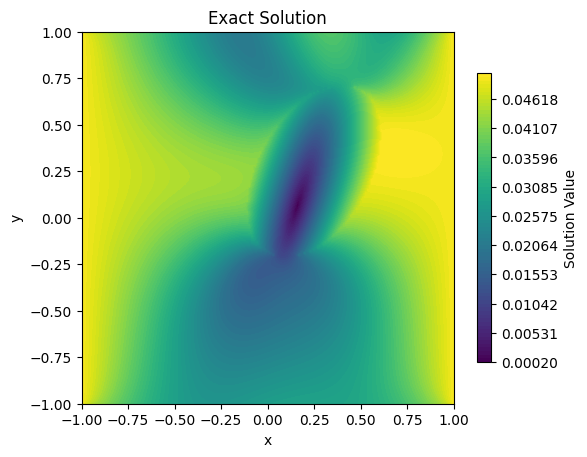

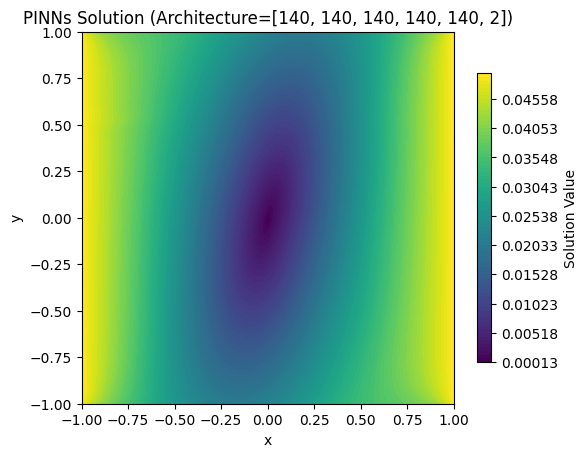

In [ ]:
# Create evaluation points
x_points = np.linspace(-side_length, side_length, 200 + 1)
y_points = np.linspace(-side_length, side_length, 200 + 1)
X, Y = np.meshgrid(x_points, y_points, indexing='ij')
X, Y = X.flatten(), Y.flatten()
eval_points = np.array([X, Y]).T

with open('PINNs_results.json', 'r') as f:
    data_results = json.load(f)

with open('PINNs_evaluation.json', 'r') as f:
    data_eval = json.load(f)

# Slice results data
domain_pts = data_results['domain_pts']
y_results = data_results['y_results']
y_gt = data_results['y_gt']

arch = data_eval['arch']
l2_rel = data_eval['l2_rel']

# Exact solution
u_exact = np.array(y_gt) # (n,)
u_exact_magnitude = np.sqrt(u_exact[:, 0]**2 + u_exact[:, 1]**2)

# Contour plot settings
# For a consistent scale across all time steps
u_min = u_exact_magnitude.min()
u_max = u_exact_magnitude.max()
# Create n levels between u_min & u_max:
num_levels = 80
levels = np.linspace(u_min, u_max, num_levels)

# Exact solution
fig1 = plt.figure(1, figsize=(6, 5))
ax1 = fig1.add_subplot(1, 1, 1)
sc1 = ax1.tricontourf(X, Y, u_exact_magnitude,
                      levels=levels, cmap='viridis')
ax1.set_title('Exact Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
fig1.colorbar(sc1, ax=ax1, shrink=0.75, label='Solution Value')

# Approximate solution
for idx, architecture in arch.items():
    # Get the approximate solution for this architecture
    u_approx = np.array(y_results[idx])  # (n,)
    u_approx_magnitude = np.sqrt(u_approx[:, 0]**2 + u_approx[:, 1]**2)

    # Contour plot settings
    # For a consistent scale across all time steps
    u_min = u_approx_magnitude.min()
    u_max = u_approx_magnitude.max()
    # Create n levels between u_min & u_max:
    num_levels = 80
    levels = np.linspace(u_min, u_max, num_levels)

    # Contour plot
    fig2 = plt.figure(2, figsize=(6, 5))
    ax2 = fig2.add_subplot(1, 1, 1)
    sc2 = ax2.tricontourf(X, Y, u_approx_magnitude,
                          levels=levels, cmap='viridis')
    ax2.set_title(f"PINNs Solution (Architecture={architecture})")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_aspect('equal', adjustable='box')
    fig2.colorbar(sc2, ax=ax2, shrink=0.75, label='Solution Value')

    # Save figures
    # fig_dir = f'./fig/arch_{idx}'
    # if not os.path.exists(fig_dir):
    #     os.makedirs(fig_dir, exist_ok=True)

    # filename = os.path.join(fig_dir, f'sol_{idx}.png')
    # fig2.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig2)


# Deformed Configuration

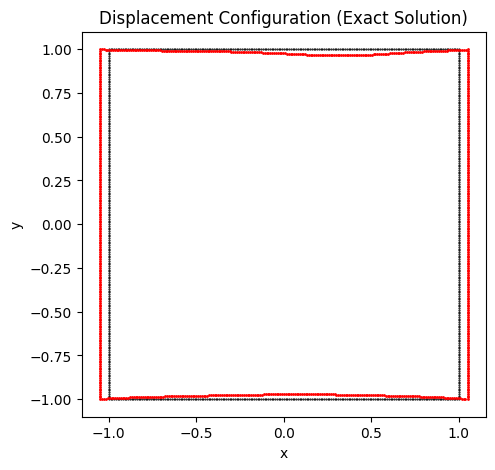

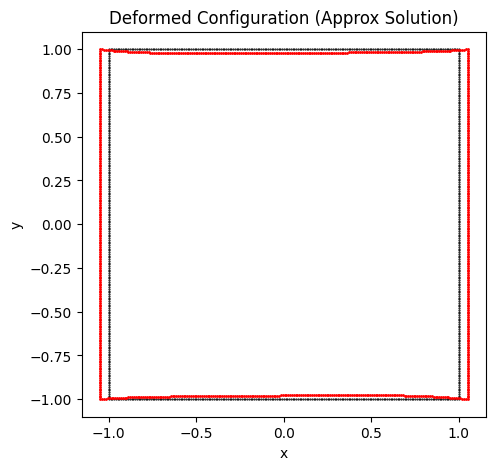

In [ ]:
# Find the boundary indices
eval_points = onp.array(eval_points)
boundary_idx = onp.where((eval_points[:, 0] == -side_length) | (eval_points[:, 0] == side_length) | (eval_points[:, 1] == -side_length) | (eval_points[:, 1] == side_length))

# Exact solution
fig_3 = plt.figure(3, figsize=(6, 5))
ax_3 = fig_3.add_subplot(1, 1, 1)
ax_3.plot(eval_points[boundary_idx, 0], eval_points[boundary_idx, 1], 'k.', markersize=1, label='Boundary')
ax_3.plot(eval_points[boundary_idx, 0] + u_exact[boundary_idx, 0], eval_points[boundary_idx, 1] + u_exact[boundary_idx, 1], 'r.', markersize=2, label='Reference')
ax_3.set_title('Displacement Configuration (Exact Solution)')
ax_3.set_xlabel('x')
ax_3.set_ylabel('y')
ax_3.set_aspect('equal', adjustable='box')
# fig_3.savefig('./fig/ref_config.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_3)

for idx, architecture in arch.items():
    u_approx_converted = onp.array(y_results[idx])


    # Approx solution
    fig_4 = plt.figure(4, figsize=(6, 5))
    ax_4 = fig_4.add_subplot(1, 1, 1)
    ax_4.plot(eval_points[boundary_idx, 0], eval_points[boundary_idx, 1], 'k.', markersize=1, label='Boundary')
    ax_4.plot(eval_points[boundary_idx, 0] + u_approx_converted[boundary_idx, 0], eval_points[boundary_idx, 1] + u_approx_converted[boundary_idx, 1], 'r.', markersize=2, label='Reference')
    ax_4.set_title('Deformed Configuration (Approx Solution)')
    ax_4.set_xlabel('x')
    ax_4.set_ylabel('y')
    ax_4.set_aspect('equal', adjustable='box')
    # fig_3.savefig('./fig/ref_config.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig_4)


# Void Configuration

{'a': Array(0.49338675, dtype=float32), 'b': Array(0.5003293, dtype=float32), 'gamma': Array(1.6513796, dtype=float32), 'x_cen': Array(0.00155509, dtype=float32), 'y_cen': Array(0.00022185, dtype=float32)}


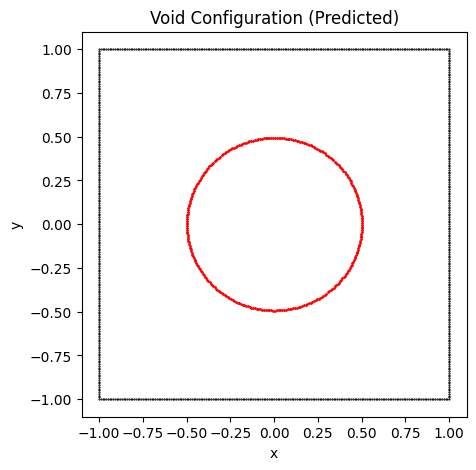

In [ ]:
geo_params = bound_params(tuned_params['geometry'], geo_bounds['lower'], geo_bounds['upper'])
print(geo_params)

# Find the boundary indices
eval_points = onp.array(eval_points)
boundary_idx = onp.where((eval_points[:, 0] == -side_length) | (eval_points[:, 0] == side_length) | (eval_points[:, 1] == -side_length) | (eval_points[:, 1] == side_length))

def ellipse(x_cen, y_cen, a, b, gamma, rotated_ang):
    x = a * np.cos(rotated_ang) * np.cos(gamma) - b * np.sin(rotated_ang) * np.sin(gamma) + x_cen
    y = a * np.cos(rotated_ang) * np.sin(gamma) + b * np.sin(rotated_ang) * np.cos(gamma) + y_cen
    return np.array([x, y]).T

boundary_points = ellipse(geo_params['x_cen'], geo_params['y_cen'],
                          geo_params['a'], geo_params['b'],
                          geo_params['gamma'], np.linspace(0, 2 * np.pi, 300))

# Exact solution
fig_5 = plt.figure(5, figsize=(6, 5))
ax_5 = fig_5.add_subplot(1, 1, 1)
ax_5.plot(eval_points[boundary_idx, 0], eval_points[boundary_idx, 1], 'k.', markersize=1, label='Boundary')
ax_5.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', markersize=2, label='Void')
ax_5.set_title('Void Configuration (Predicted)')
ax_5.set_xlabel('x')
ax_5.set_ylabel('y')
ax_5.set_aspect('equal', adjustable='box')
# fig_3.savefig('./fig/ref_config.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig_3)


# Error Plots

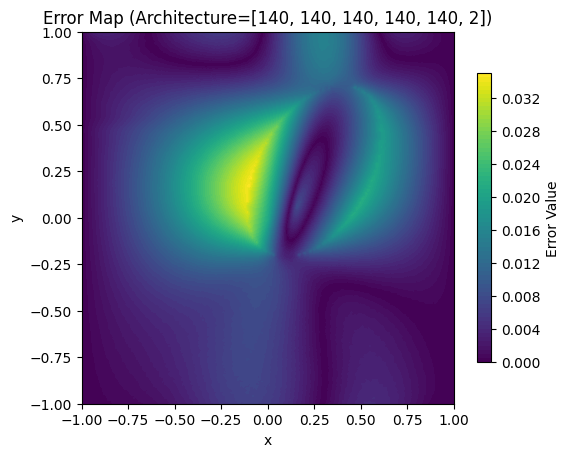

In [ ]:
# Exact solution
u_exact = np.array(y_gt) # (n,)
u_exact_magnitude = np.sqrt(u_exact[:, 0]**2 + u_exact[:, 1]**2)

# Contour plot settings
levels = 80

# Approximate solution
for idx, architecture in arch.items():
    # Get the approximate solution for this architecture
    u_approx = np.array(y_results[idx])  # (n,)
    u_approx_magnitude = np.sqrt(u_approx[:, 0]**2 + u_approx[:, 1]**2)
    error_val = np.abs(u_approx_magnitude - u_exact_magnitude)

    # Contour plot
    fig_error = plt.figure(1, figsize=(6, 5))
    ax_error = fig_error.add_subplot(1, 1, 1)
    sc_error = ax_error.tricontourf(X, Y, error_val,
                                    levels=levels, cmap='viridis')
    ax_error.set_title(f"Error Map (Architecture={architecture})")
    ax_error.set_xlabel("x")
    ax_error.set_ylabel("y")
    ax_error.set_aspect('equal', adjustable='box')
    fig_error.colorbar(sc_error, ax=ax_error, shrink=0.75, label='Error Value')

    plt.show()
    plt.close(fig1)


# Loss Plots

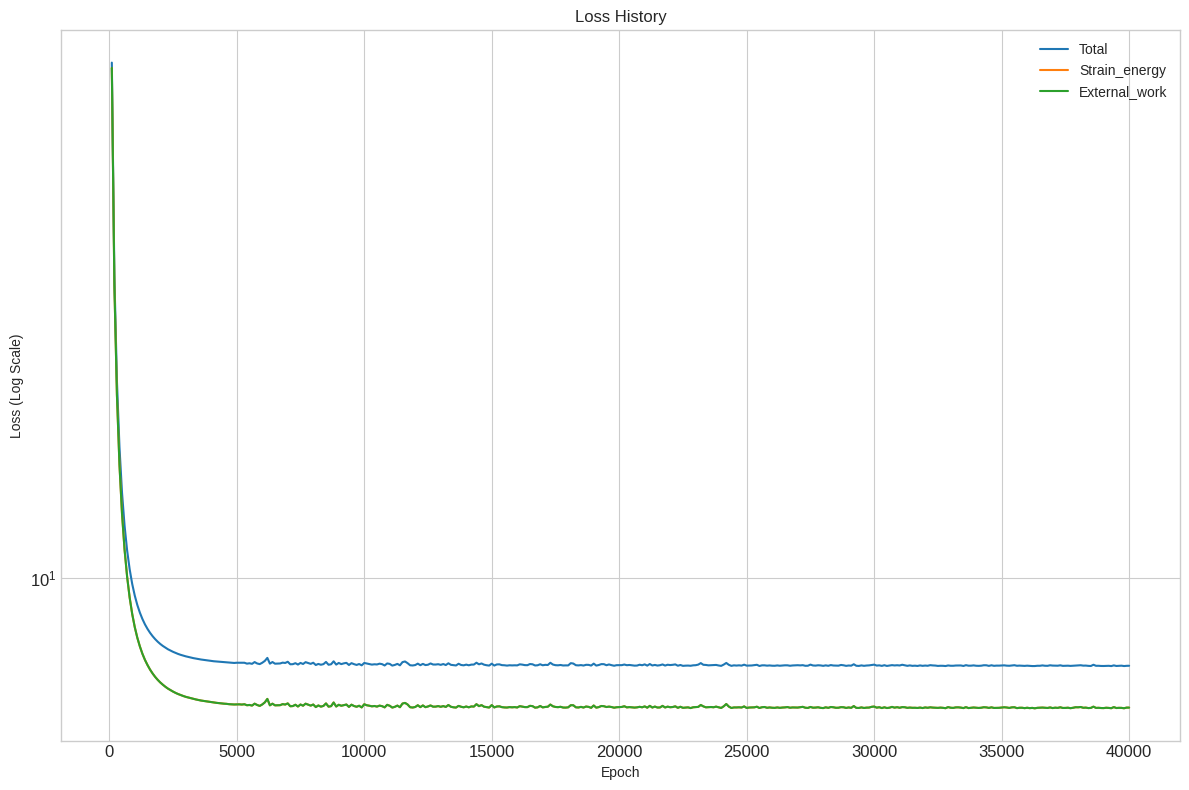

In [ ]:
with open('PINNs_evaluation.json', 'r') as f:
    data_eval = json.load(f)

# Slice results data
arch = data_eval['arch']
l2_rel = data_eval['l2_rel']
losses_adam = data_eval['losses_adam']

for idx, architecture in arch.items():
    loss_adam_history = losses_adam[idx]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig_loss, ax_loss = plt.subplots(figsize=(12, 8))

    # Generate X-axis (Adam)
    num_data_points = len(loss_history['total'])
    adam_epochs = [(i + 1) * 100 for i in range(num_data_points)]
    # Find the last epoch number from Adam to start the L-BFGS count
    last_adam_epoch = adam_epochs[-1] if adam_epochs else 0

    # Plot Each Loss Term
    for loss_name in loss_adam_history.keys():
        ax_loss.plot(adam_epochs, loss_adam_history[loss_name], label=loss_name.capitalize())
    # ax_loss.plot(epochs, loss_history['dirichlet1'], label=loss_name.capitalize())
    # ax_loss.plot(epochs, loss_history['dirichlet2'], label=loss_name.capitalize())

    ax_loss.set_yscale('log') # Use a logarithmic scale
    ax_loss.legend(loc='upper right', fontsize=10)
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss (Log Scale)')
    ax_loss.set_title(f'Loss History')
    ax_loss.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()
    plt.close(fig_loss)

# Geometric Parameters Plot

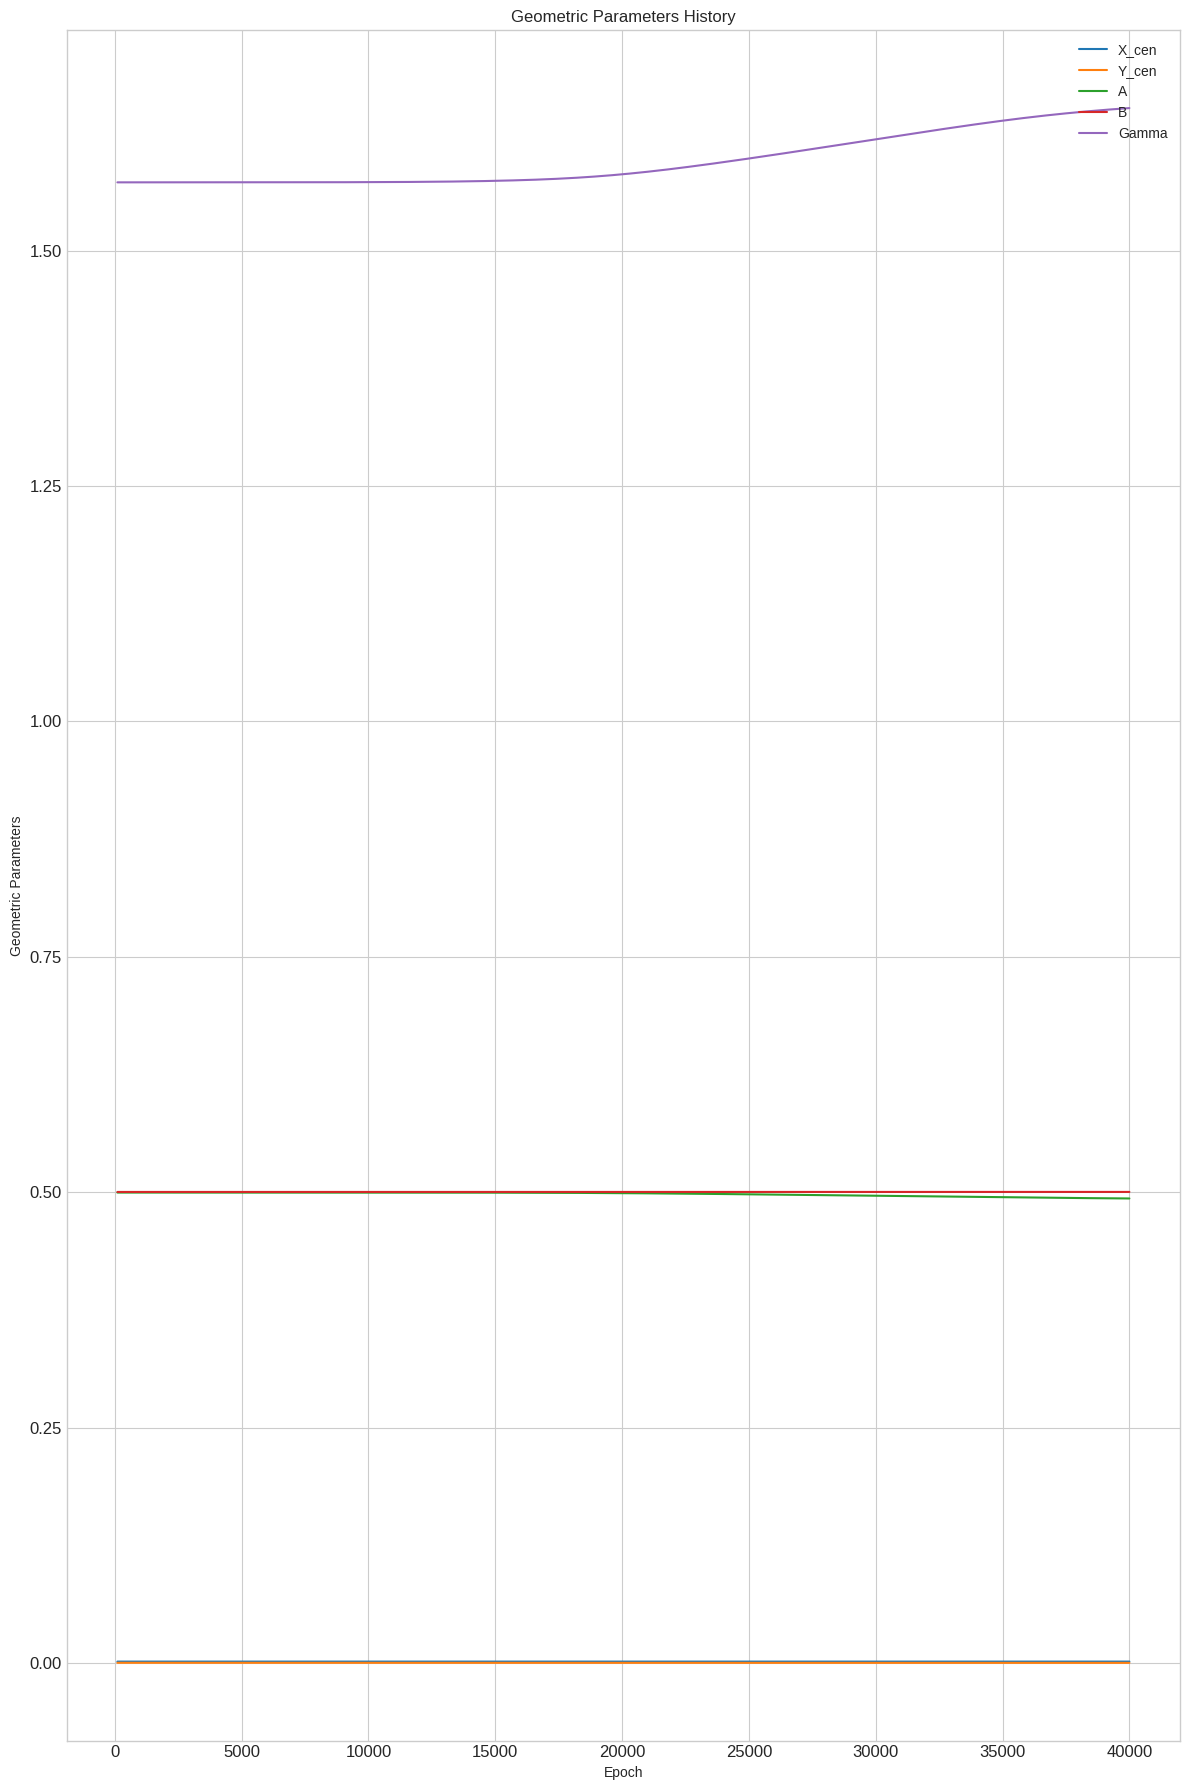

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig_geo, ax_geo = plt.subplots(figsize=(12, 18), sharex=True)

# Generate X-axis (Adam)
num_data_points = len(geo_history['x_cen'])
adam_epochs = [(i + 1) * 100 for i in range(num_data_points)]

# Plot Each Loss Term
for geo_name in geo_history.keys():
    ax_geo.plot(adam_epochs, geo_history[geo_name], label=geo_name.capitalize())

ax_geo.legend(loc='upper right', fontsize=10)
ax_geo.set_xlabel('Epoch')
ax_geo.set_ylabel('Geometric Parameters')
ax_geo.set_title(f'Geometric Parameters History')
ax_geo.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()
plt.close(fig_geo)

In [ ]:
l2_rel

{'0': 0.34295204281806946}